In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 12
NN_SHAPES = jnp.array([64, 64, 64])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)

BETA = 0.5
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5
UTILITY_CONSTANT = 10.
EPSILON = 1e-5

In [3]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(3, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
w2 = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1] + 4, NN_SHAPES[2]))
wf = SCALE * jax.random.normal(INIT_KEYS[3], shape=(NN_SHAPES[2],))
b0 = SCALE * jax.random.normal(INIT_KEYS[4], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, NN_SHAPES[1]))
b2 = SCALE * jax.random.normal(INIT_KEYS[6], shape=(1, NN_SHAPES[2]))
bf = SCALE * jax.random.normal(INIT_KEYS[7], shape=(1,))
params0 = {'w0': w0, 'w1': w1, 'vw2': w2, 'cw2': w2, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'vb2': b2, 'cb2': b2, 'vbf': bf, 'cbf': bf}

In [4]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e6)


@jax.jit
def neural_network(params, x, t, o):
    x += o * INTEREST * x # If the agent is an owner, collect interest on savings
    po = (1 - o) * jnp.int32(x >= MIN_DP)
    
    l0 = jnp.concatenate((x[jnp.newaxis], t[jnp.newaxis], o[jnp.newaxis]))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    
    cl0 = jnp.concatenate((l0, po[jnp.newaxis]))
    cl3 = relu(jnp.concatenate((cl0, l2)), params['cw2'], params['cb2'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select(t[jnp.newaxis] >= MAX_AGE, x[jnp.newaxis], cu)
    
    o1 = jnp.minimum(o + jnp.int32(x - c >= MIN_DP), 1.) # If the agent saves enough they can become an owner
    
    vl0 = jnp.concatenate((l0, o1))
    vl3 = relu(jnp.concatenate((vl0, l2)), params['vw2'], params['vb2'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select(t[jnp.newaxis] > MAX_AGE, jnp.zeros(1), vu)
    
    return jnp.concatenate((v, c, x - c, o1))


@jax.jit
def loss(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, t + 1, o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, t + 1, 0.)
    v1o = vf(params, x1, t + 1, 1.)
    v_diff = v1o - v1r
    
    c0x = jax.grad(lambda x: neural_network(params, x, t, o)[1])(x)
    v0x = jax.grad(vf, (1))(params, x, t, o)
    v1x = jax.grad(vf, (1))(params, x1, t + 1, o1)
    
    loss_bellman = ((UTILITY_CONSTANT * jnp.log(c0) + BETA * v1) - v0)
    loss_foc = BETA * (1 + o1 * INTEREST) * v1x * c0 - 1
    loss_envelope = (c0x - v0x * c0)
    
    return jnp.array([loss_bellman, loss_foc, loss_envelope])


@jax.jit
def batch_loss(params, xs, ts, os, W=jnp.diag(jnp.ones(3))):
    losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, xs, ts, os)
    return  jnp.mean(jax.vmap(lambda l: l @ W @ l.T)(losses))

In [5]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000),
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), 
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000), 
                         jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000)))
all_O = jnp.concatenate((jnp.zeros(1000), jnp.zeros(1000), jnp.zeros(1000),
                         jnp.ones(1000), jnp.ones(1000), jnp.ones(1000)))


def training_loop(X, T, O, opt_state, opt_update, get_params, W=jnp.diag(jnp.ones(3)), max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss = batch_loss(get_params(best_opt_state), all_X, all_T, all_O)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (3, MB))
        params = get_params(opt_state)

        val_loss, grad = jax.value_and_grad(batch_loss)(get_params(opt_state), X[sample[0]], T[sample[1]], O[sample[2]], W=W)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss = batch_loss(params, all_X, all_T, all_O)
            if fair_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2e}\tFair Loss: {fair_loss:.2e}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}')
        
    return opt_state, best_opt_state

In [6]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
init_opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))
O = jnp.concatenate((jnp.zeros(500), jnp.ones(500)))
W = jnp.diag(jnp.array([1e-1, 1., 1e-1]))
if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = best_opt_state

current_opt_state, best_opt_state = training_loop(X, T, O, opt_state, opt_update, get_params, W=W, max_iter=10000)

Iteration: 100	Current Loss: 9.69e+00	Fair Loss: 8.58e+01	Average samples/s: 31569.47
Iteration: 200	Current Loss: 8.60e+00	Fair Loss: 8.24e+01	Average samples/s: 31075.16
Iteration: 300	Current Loss: 8.27e+00	Fair Loss: 8.03e+01	Average samples/s: 31289.64
Iteration: 400	Current Loss: 8.10e+00	Fair Loss: 7.88e+01	Average samples/s: 31019.45
Iteration: 500	Current Loss: 9.17e+00	Fair Loss: 7.66e+01	Average samples/s: 30775.47
Iteration: 600	Current Loss: 7.82e+00	Fair Loss: 7.54e+01	Average samples/s: 30570.62
Iteration: 700	Current Loss: 7.33e+00	Fair Loss: 7.62e+01	Average samples/s: 30538.41
Iteration: 800	Current Loss: 8.60e+00	Fair Loss: 7.63e+01	Average samples/s: 30379.90
Iteration: 900	Current Loss: 8.19e+00	Fair Loss: 7.73e+01	Average samples/s: 30516.09
Iteration: 1000	Current Loss: 6.41e+00	Fair Loss: 7.25e+01	Average samples/s: 30455.10
Iteration: 1100	Current Loss: 6.98e+00	Fair Loss: 6.82e+01	Average samples/s: 30405.81
Iteration: 1200	Current Loss: 6.51e+00	Fair Loss: 6.

Iteration: 9600	Current Loss: 3.48e+00	Fair Loss: 3.19e+01	Average samples/s: 29508.74
Iteration: 9700	Current Loss: 3.62e+00	Fair Loss: 3.15e+01	Average samples/s: 29490.91
Iteration: 9800	Current Loss: 4.08e+00	Fair Loss: 3.22e+01	Average samples/s: 29488.16
Iteration: 9900	Current Loss: 4.10e+00	Fair Loss: 3.19e+01	Average samples/s: 29481.96
Iteration: 10000	Current Loss: 3.84e+00	Fair Loss: 3.18e+01	Average samples/s: 29462.47


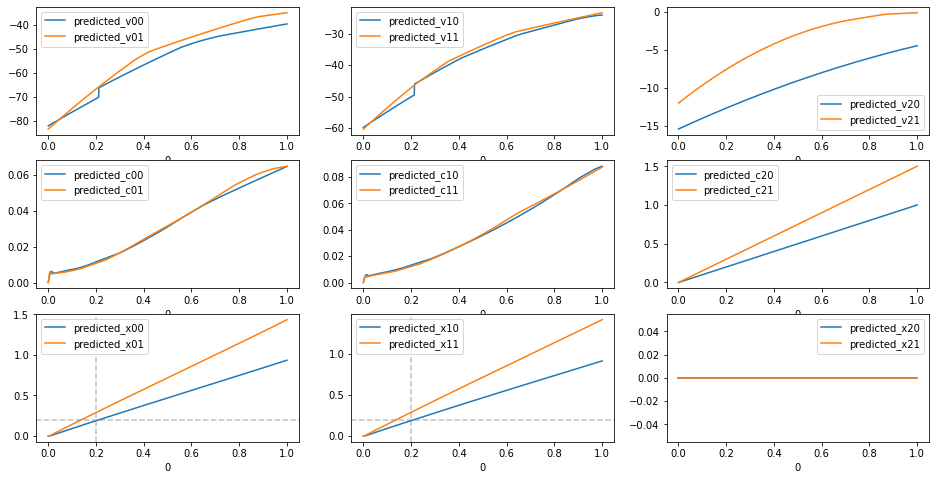

In [7]:
params = get_params(best_opt_state)

init00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 0.)
pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 0.)

init10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 0.)

init20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 0.)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 1.)

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 1.)

init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 1.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init00, pred00, init10, pred10, init20, pred20,
                                   init01, pred01, init11, pred11, init21, pred21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v00', 'initial_c00', 'initial_x00', 'initial_o10', 'predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'initial_v10', 'initial_c10', 'initial_x10', 'initial_o20', 'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'initial_v20', 'initial_c20', 'initial_x20', 'initial_o30', 'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'initial_v01', 'initial_c01', 'initial_x00', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

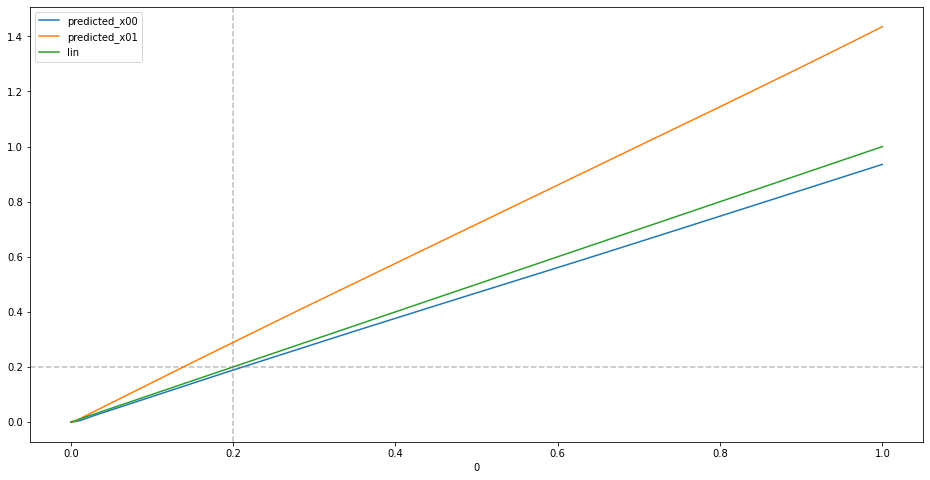

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
df['lin'] = jnp.linspace(1e-5, 1, 1000)
df.plot(y=['predicted_x00', 'predicted_x01', 'lin'], ax=ax)
ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

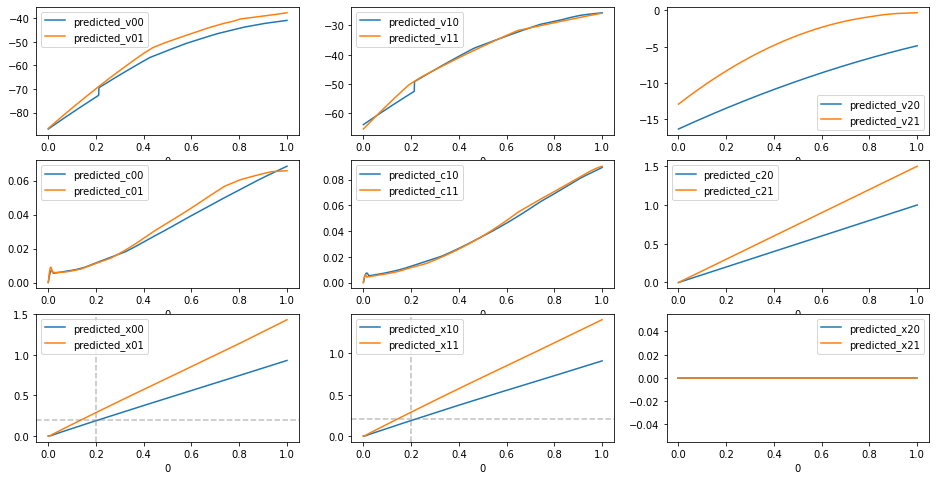

In [9]:
params = get_params(current_opt_state)

init00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 0.)
pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 0.)

init10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 0.)

init20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 0.)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 1.)

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 1.)

init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 1.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init00, pred00, init10, pred10, init20, pred20,
                                   init01, pred01, init11, pred11, init21, pred21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v00', 'initial_c00', 'initial_x00', 'initial_o10', 'predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'initial_v10', 'initial_c10', 'initial_x10', 'initial_o20', 'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'initial_v20', 'initial_c20', 'initial_x20', 'initial_o30', 'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'initial_v01', 'initial_c01', 'initial_x00', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

We should see that once starting wealth (x-axis) is above 0.4, it is possible for the renter to try and become a homeowner, so the savings function (x_00) should bend up to the horizontal grey line. Instead we see it stays completely linear, the renter is indifferent to becoming a homeowner, even though we have estimated correctly that the homeowner has a higher value.

In [10]:
losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, all_X, all_T, all_O)
jnp.mean(losses**2, axis=0)

DeviceArray([23.452785 ,  0.6237256,  9.51177  ], dtype=float32)

In [11]:
batch_loss(params, all_X[0:1000], all_T[0:1000], all_O[0:1000])

DeviceArray(6.1186614, dtype=float32)

In [12]:
batch_loss(params, all_X[1000:2000], all_T[1000:2000], all_O[1000:2000])

DeviceArray(8.71582, dtype=float32)

In [13]:
batch_loss(params, all_X[2000:3000], all_T[2000:3000], all_O[2000:3000])

DeviceArray(82.40908, dtype=float32)

In [14]:
batch_loss(params, all_X[3000:4000], all_T[3000:4000], all_O[3000:4000])

DeviceArray(7.7609363, dtype=float32)

In [15]:
#     live_next = (t < MAX_AGE)
#     loss_euler = 0 # jax.lax.select(live_next, 
#                                 jax.lax.select(o == 1.,
#                                                1e2 * (c1 - ((BETA * (1 + INTEREST)) * c0)),
#                                                jax.lax.select(x1 >= MIN_DP,
#                                                               0.,
#                                                               # (BETA * c0 * (v1x + (v_diff / (MIN_DP - x1))) - 1))),
#                                                               # c1 - BETA * c0 * (1 + jnp.int32(jnp.isclose(x1, MIN_DP)) * v_diff * c1))), 
#                                                               # (c1 - BETA) * c0 + jnp.maximum(0, v_diff - (MIN_DP - x1) / c0))),
#                                                               (BETA * c0) - (c1 * (1 + BETA * c0 * jnp.int32(x1 + EPSILON > MIN_DP) * v_diff / EPSILON)))), 
#                                 0.)